# Implementacion de modelo de Aprendizaje automatico en un contexto real para la prediccion

## Juan Camilo Chaparro Castellanos | Sebastian Escobar Osorio
## CC 1039466438 | CC 1017231742

In [1]:
import librosa as lr
import numpy as np
from IPython.display import Audio
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import pandas as pd
import scipy as sp
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import seaborn as sbn
from sklearn.decomposition import PCA
import cv2
import os
from skimage.feature import hog, multiblock_lbp

#### A continuacion se realiza la lectura del siguiente dataseet 

https://www.kaggle.com/datasets/kirlelea/spanish-sign-language-alphabet-static

#### Se redimensionan las imagenes del dataseet a un tamaño pertinente, se seleccionan 5 de las 19 Señas, en este caso las señas "A,B,G,S y P" para continuar con el preprocesamiento

In [2]:
import cv2
import os
from skimage import color as skic
from skimage import filters as skif

# Rutas de las imágenes
src_dir = '../../Base de datos de señas/fondo_blanco'
dst_dir = 'images_redimen/'

# Carpetas permitidas
allowed_folders = {'A', 'B', 'G', 'S', 'P'}

# Crear directorio de destino si no existe
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

# Iterar sobre carpetas permitidas
for folder in allowed_folders:
    folder_path = os.path.join(src_dir, folder)
    dst_folder_path = os.path.join(dst_dir, folder)

    # Crear subcarpeta en destino si no existe
    if not os.path.exists(dst_folder_path):
        os.makedirs(dst_folder_path)

    if os.path.isdir(folder_path):
        # Obtener imágenes de la carpeta
        imgs = [f for f in os.listdir(folder_path) if f.endswith(('.JPG', '.png', '.jpeg'))]

        # Iterar sobre imágenes
        for i, img_name in enumerate(imgs):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error al leer la imagen: {img_path}")
                continue

            # Convertir a RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Redimensionar
            h, w, _ = img_rgb.shape
            new_size = (int(w * 0.1), int(h * 0.1))
            img_resized = cv2.resize(img_rgb, new_size, interpolation=cv2.INTER_AREA)
            
            # Guardar imagen redimensionada
            out_path = os.path.join(dst_folder_path, f'{i+1:02}.jpg')
            cv2.imwrite(out_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))


#### Antes de realizar la caracterizacion, deseamos ver el comportamiento de los diferentes ordenes que se puede generar para procesar una imagen (escala de grises, segmentacion y sobel)

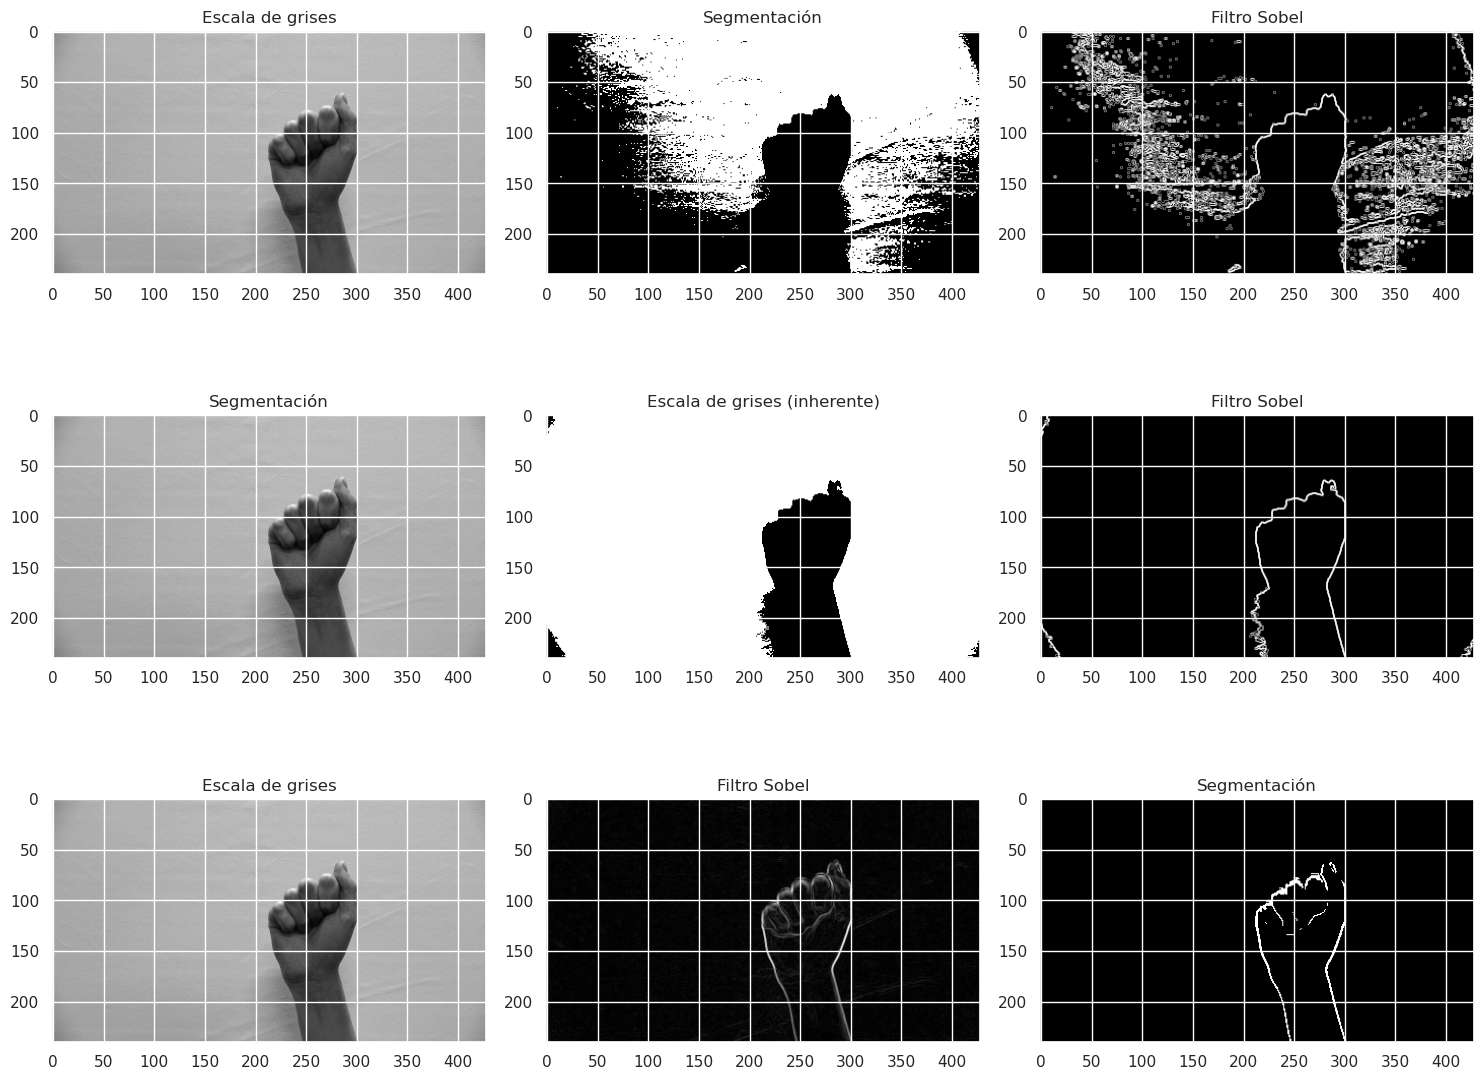

In [3]:
# Leer la imagen original
imagen_color = cv2.imread('./images_redimen/A/17.jpg')
imagen_gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)

# 1. Escala de grises → Segmentación → Filtro Sobel
# ---------------------------------------------------------------------
# Paso 1: Escala de grises ya obtenida (imagen_gris)
# Paso 2: Segmentación
_, umbral_1 = cv2.threshold(imagen_gris, 139, 255, cv2.THRESH_BINARY)
# Paso 3: Filtro Sobel sobre la imagen segmentada
imagen_sobel_1 = skif.sobel(umbral_1.astype('float'))

# 2. Segmentación → Escala de grises → Filtro Sobel
# ---------------------------------------------------------------------
# Paso 1: Segmentación
_, umbral_2 = cv2.threshold(imagen_gris, 118, 255, cv2.THRESH_BINARY)
# Paso 2: Escala de grises no aplica aquí directamente, porque la segmentación es binaria,
# pero seguimos con el mismo resultado binario.
imagen_segmentada_2 = umbral_2
# Paso 3: Filtro Sobel
imagen_sobel_2 = skif.sobel(imagen_segmentada_2.astype('float'))

# 3. Escala de grises → Filtro Sobel → Segmentación
# ---------------------------------------------------------------------
# Paso 1: Escala de grises ya obtenida (imagen_gris)
# Paso 2: Filtro Sobel sobre la escala de grises
imagen_sobel_3 = skif.sobel(imagen_gris)
# Paso 3: Segmentación sobre la imagen Sobel
_, umbral_sobel_3 = cv2.threshold((imagen_sobel_3 * 255).astype('uint8'), 20, 255, cv2.THRESH_BINARY)

# Visualización de los resultados
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

# Escala de grises → Segmentación → Filtro Sobel
ax[0, 0].imshow(imagen_gris, cmap='gray')
ax[0, 0].set_title('Escala de grises')
ax[0, 1].imshow(umbral_1, cmap='gray')
ax[0, 1].set_title('Segmentación')
ax[0, 2].imshow(imagen_sobel_1, cmap='gray')
ax[0, 2].set_title('Filtro Sobel')

# Segmentación → Escala de grises → Filtro Sobel
ax[1, 0].imshow(imagen_gris, cmap='gray')
ax[1, 0].set_title('Segmentación')
ax[1, 1].imshow(imagen_segmentada_2, cmap='gray')
ax[1, 1].set_title('Escala de grises (inherente)')
ax[1, 2].imshow(imagen_sobel_2, cmap='gray')
ax[1, 2].set_title('Filtro Sobel')

# Escala de grises → Filtro Sobel → Segmentación
ax[2, 0].imshow(imagen_gris, cmap='gray')
ax[2, 0].set_title('Escala de grises')
ax[2, 1].imshow(imagen_sobel_3, cmap='gray')
ax[2, 1].set_title('Filtro Sobel')
ax[2, 2].imshow(umbral_sobel_3, cmap='gray')
ax[2, 2].set_title('Segmentación')

# Ajustar los márgenes
plt.tight_layout()
plt.show()

#### Para nuestro caso seleccionamos el orden #3 que consiste en (Escalado de grises, filtro sobel y por ultimo segmentacion ya que se puede identificar de mejor manera el simbolo de seña el cual deseamos identificar

In [4]:
# Carpeta base que contiene las subcarpetas
directorio_base = './images_redimen'
# Carpeta donde se guardarán las imágenes procesadas
directorio_salida = './images_procesadas'

# Crear la carpeta de salida si no existe
if not os.path.exists(directorio_salida):
    os.makedirs(directorio_salida)

# Carpetas específicas a procesar
carpetas_a_procesar = ['A', 'B', 'G', 'P', 'S']

# Recorrer las carpetas específicas (A, B, G, P, S)
for nombre_carpeta in carpetas_a_procesar:
    ruta_carpeta = os.path.join(directorio_base, nombre_carpeta)
    
    if not os.path.exists(ruta_carpeta):
        print(f"El directorio {nombre_carpeta} no existe.")
        continue

    # Crear una subcarpeta para cada carpeta procesada dentro de images_procesadas
    ruta_salida_carpeta = os.path.join(directorio_salida, nombre_carpeta)
    if not os.path.exists(ruta_salida_carpeta):
        os.makedirs(ruta_salida_carpeta)

    for archivo in os.listdir(ruta_carpeta):
        if archivo.lower().endswith(('.jpg', '.png', '.jpeg')):  # Filtrar solo imágenes
            ruta_imagen = os.path.join(ruta_carpeta, archivo)
            imagen = cv2.imread(ruta_imagen)

            if imagen is None:
                print(f"No se puede abrir la imagen en la ruta: {ruta_imagen}")
                continue

            # Paso 1: Convertir a escala de grises
            imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

            # Paso 2: Aplicar el filtro Sobel sobre la imagen en escala de grises
            imagen_sobel = skif.sobel(imagen_gris)

            # Paso 3: Segmentación sobre la imagen Sobel
            _, umbral_sobel = cv2.threshold((imagen_sobel * 255).astype('uint8'), 20, 255, cv2.THRESH_BINARY)

            # Guardar la imagen procesada (gris -> sobel -> segmentación)
            ruta_guardar = os.path.join(ruta_salida_carpeta, f"{os.path.splitext(archivo)[0]}_procesada.jpg")
            cv2.imwrite(ruta_guardar, umbral_sobel)


print("Proceso completado.")


Proceso completado.


In [5]:
import os

# Directorio base donde están las carpetas de símbolos
directorio_base = './images_redimen'

# Obtener todas las carpetas/clases disponibles
clases = [carpeta for carpeta in os.listdir(directorio_base) if os.path.isdir(os.path.join(directorio_base, carpeta))]

# Contar la cantidad de imágenes por clase
clases_info = {}
for clase in clases:
    ruta_clase = os.path.join(directorio_base, clase)
    num_imagenes = len([archivo for archivo in os.listdir(ruta_clase) if archivo.endswith(('.jpg', '.png', '.jpeg'))])
    clases_info[clase] = num_imagenes

# Mostrar la cantidad de imágenes por clase
print("Cantidad de imágenes por clase:")
for clase, cantidad in clases_info.items():
    print(f"Clase {clase}: {cantidad} imágenes")


Cantidad de imágenes por clase:
Clase B: 95 imágenes
Clase S: 100 imágenes
Clase G: 108 imágenes
Clase A: 102 imágenes
Clase P: 110 imágenes


#### Luego procedemor a realizar la extraccion de caracteristicas

In [6]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage import feature
from skimage.feature import hog
from skimage.color import rgb2gray
from scipy.stats import skew, kurtosis

# Carpeta base que contiene las subcarpetas
directorio_base = './images_procesadas'

# Función para extraer estadísticas básicas de la imagen
def extraer_estadisticas(img):
    stats = {
        'media': np.mean(img),
        'varianza': np.var(img),
        'asimetria': skew(img.flatten()),
        'curtosis': kurtosis(img.flatten()),
        'maximo': np.max(img),
        'minimo': np.min(img)  # Agregar valor mínimo de la imagen
    }
    return stats

# Función para extraer estadísticas de Fourier
def extraer_estadisticas_fourier(img):
    f_transform = np.fft.fft2(img)
    f_transform = np.fft.fftshift(f_transform)
    magnitud_espectro = np.abs(f_transform)
    
    estadisticas_fourier = {
        'medias_fourier': np.mean(magnitud_espectro),
        'varianzas_fourier': np.var(magnitud_espectro),
        'asimetria_fourier': skew(magnitud_espectro.flatten()),
        'curtosis_fourier': kurtosis(magnitud_espectro.flatten()),
        'maximos_fourier': np.max(magnitud_espectro),
        'minimos_fourier': np.min(magnitud_espectro)
    }
    return estadisticas_fourier

# Función para extraer HOG
def extraer_hog(img):
    hog_features, _ = hog(
        img, 
        pixels_per_cell=(64, 64),  # Aumenta el tamaño de la celda para reducir el número de celdas
        cells_per_block=(1, 1),    # Disminuye el tamaño del bloque para reducir la superposición
        orientations=8,            # Menos orientaciones para disminuir el número de bins en los histogramas
        visualize=True, 
        channel_axis=None
    )
    return hog_features

# Función para extraer LBP
def extraer_lbp(img):
    lbp = feature.local_binary_pattern(img, P=8, R=1, method='default')
    (hist, _) = np.histogram(lbp, bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

# Lista para almacenar todas las características de las imágenes
lista_todas_caracteristicas = []

# Carpetas específicas a procesar
carpetas_a_procesar = ['A', 'B', 'G', 'P', 'S']

# Recorrer las carpetas específicas (A, B, G, P, S)
for nombre_carpeta in carpetas_a_procesar:
    ruta_carpeta = os.path.join(directorio_base, nombre_carpeta)
    
    if not os.path.exists(ruta_carpeta):
        print(f"El directorio {nombre_carpeta} no existe.")
        continue

    for archivo in os.listdir(ruta_carpeta):
        if archivo.lower().endswith('.jpg'):
            ruta_imagen = os.path.join(ruta_carpeta, archivo)
            imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    
            if imagen is None:
                print(f"No se puede abrir la imagen en la ruta: {ruta_imagen}")
                continue
    
            # Extraer las características de la imagen
            stats = extraer_estadisticas(imagen)
            estadisticas_fourier = extraer_estadisticas_fourier(imagen)
            hog_features = extraer_hog(imagen)
            lbp_features = extraer_lbp(imagen)
    
            # Separar las características del HOG en columnas individuales
            hog_dict = {f'hog_{i}': hog_features[i] for i in range(len(hog_features))}
    
            # Separar las características del LBP en columnas individuales
            lbp_dict = {f'lbp_{i}': lbp_features[i] for i in range(len(lbp_features))}
    
            # Unir todas las características en un solo diccionario
            all_features = {**stats, **estadisticas_fourier, **hog_dict, **lbp_dict,'clase': nombre_carpeta}
    
            # Agregar las características a la lista
            lista_todas_caracteristicas.append(all_features)

# Crear un DataFrame con todas las características
df = pd.DataFrame(lista_todas_caracteristicas)

# Mostrar el DataFrame resultante
print(df)

# Guardar el DataFrame en un archivo CSV
df.to_csv('caracteristicas_imagenes_final.csv', index=False)

        media     varianza  asimetria   curtosis  maximo  minimo  \
0    2.499153   623.116744   9.990403  97.819966     255       0   
1    3.508294   870.141228   8.385312  68.322849     255       0   
2    2.685933   667.142396   9.637975  90.904360     255       0   
3    2.643575   657.552283   9.713283  92.360743     255       0   
4    2.990226   743.053682   9.111423  81.029046     255       0   
..        ...          ...        ...        ...     ...     ...   
510  4.872800  1201.687539   7.056224  47.797237     255       0   
511  4.182097  1033.521815   7.651454  56.553142     255       0   
512  4.222518  1044.114028   7.610845  55.933029     255       0   
513  4.164544  1030.658673   7.663626  56.738868     255       0   
514  3.417504   845.904974   8.509185  70.417546     255       0   

     medias_fourier  varianzas_fourier  asimetria_fourier  curtosis_fourier  \
0       4900.852235       4.062976e+07           8.483434        172.534938   
1       5805.543935      

#### Tenemos que generamos las clases de nuestro dataseet

## Clasificacion 

In [24]:
# Crear un diccionario con las clases y sus índices
class_labels = {class_name: i for i, class_name in enumerate(clases)}
# etiquetas de clase
print(class_labels)


{'B': 0, 'S': 1, 'G': 2, 'A': 3, 'P': 4}


# Aplicacion de Regresiones Logisticas

In [25]:
#Normalizacion de los datos
def normalize_min_max(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

#Estandarizacion de los datos
def estandarizar(datos):
    media = np.mean(datos)
    sigma = np.std(datos)
    datos_estandarizados = (datos - media) / sigma
    return datos_estandarizados

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Separar las características (X) y las etiquetas (YN)
X = df.drop(columns=['clase'])  # Eliminamos la columna 'clase'
YN = df['clase']  # Las etiquetas se almacenan en YN

# Normalizar las características utilizando MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalizamos todas las columnas excepto 'clase'

# Generar un eje x en función del número de datos
N = len(X_normalized)
X_axis = np.linspace(0, N, N)

# Imprimir tamaños de los datos
print(f"Total de características normalizadas: {N}")


Total de características normalizadas: 515


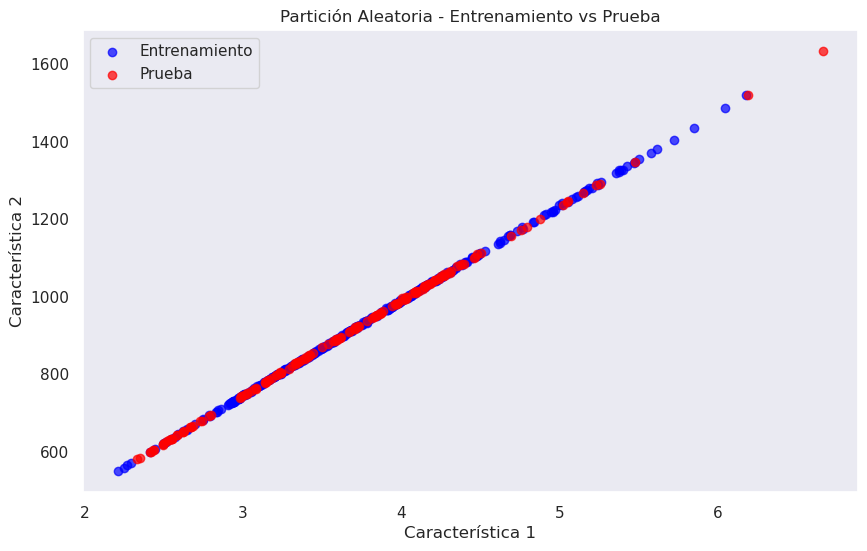

Tamaño del conjunto de entrenamiento: 360 muestras
Tamaño del conjunto de prueba: 155 muestras


In [30]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que 'X' son las características y 'YN' las etiquetas
X_train, X_test, y_train, y_test = train_test_split(X, YN, test_size=0.3, random_state=42)

# Convertir a NumPy si es necesario
if hasattr(X_train, 'values'):  # Si es un DataFrame de pandas
    X_train_np = X_train.values
    X_test_np = X_test.values
else:
    X_train_np = X_train
    X_test_np = X_test

# Verificar que X_train y X_test tengan al menos dos columnas para graficar
if X_train_np.shape[1] >= 2 and X_test_np.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train_np[:, 0], X_train_np[:, 1], color='blue', alpha=0.7, label='Entrenamiento')
    plt.scatter(X_test_np[:, 0], X_test_np[:, 1], color='red', alpha=0.7, label='Prueba')
    plt.title('Partición Aleatoria - Entrenamiento vs Prueba')
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No hay suficientes características para graficar (se necesitan al menos 2 columnas).")

# Imprimir tamaños de los datos
print(f"Tamaño del conjunto de entrenamiento: {X_train_np.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test_np.shape[0]} muestras")


# SVM


Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.85      0.44      0.58        39
           B       0.52      0.58      0.55        24
           G       0.31      0.52      0.39        33
           P       0.35      0.68      0.46        28
           S       0.00      0.00      0.00        31

    accuracy                           0.43       155
   macro avg       0.41      0.44      0.40       155
weighted avg       0.42      0.43      0.40       155



/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

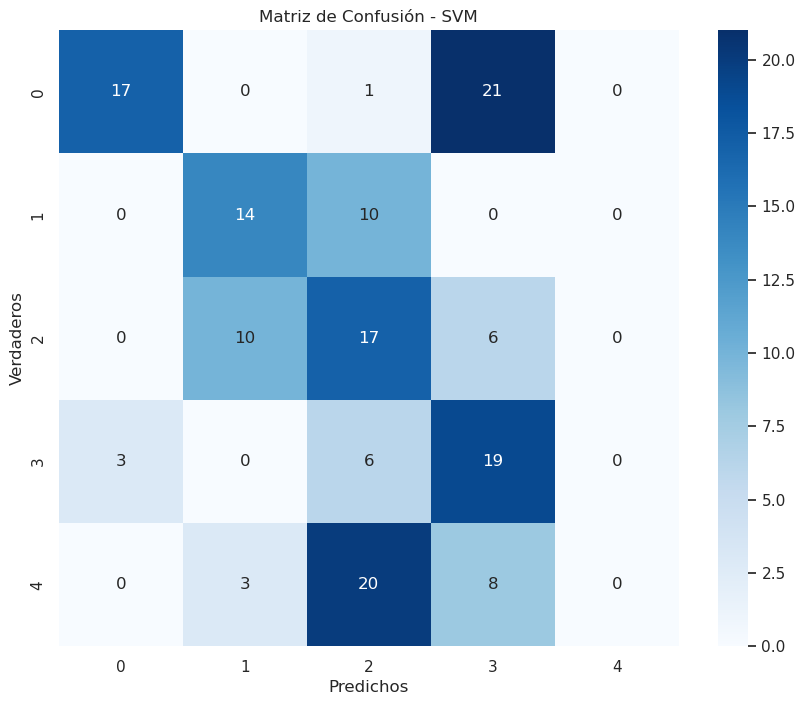


Precisión en entrenamiento: 0.4722
Precisión en prueba: 0.4323

Algunas predicciones de ejemplo:
Real: G, Predicho: G
Real: S, Predicho: G
Real: S, Predicho: P
Real: B, Predicho: G
Real: S, Predicho: G


In [37]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


# Crear y entrenar el modelo SVM con kernel RBF
svm_model = SVC(kernel='rbf', random_state=42)

# Asegurarse de usar los datos escalados y las etiquetas adecuadas
svm_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Evaluar el modelo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Crear y mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy = svm_model.score(X_train, y_train)
test_accuracy = svm_model.score(X_test, y_test)
print(f"\nPrecisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")

# Mostrar algunas predicciones para algunas muestras de prueba
print("\nAlgunas predicciones de ejemplo:")
for i in range(min(5, len(y_test))):
    print(f"Real: {y_test.iloc[i] if hasattr(y_test, 'iloc') else y_test[i]}, "
          f"Predicho: {y_pred[i]}")

# OneVsAll

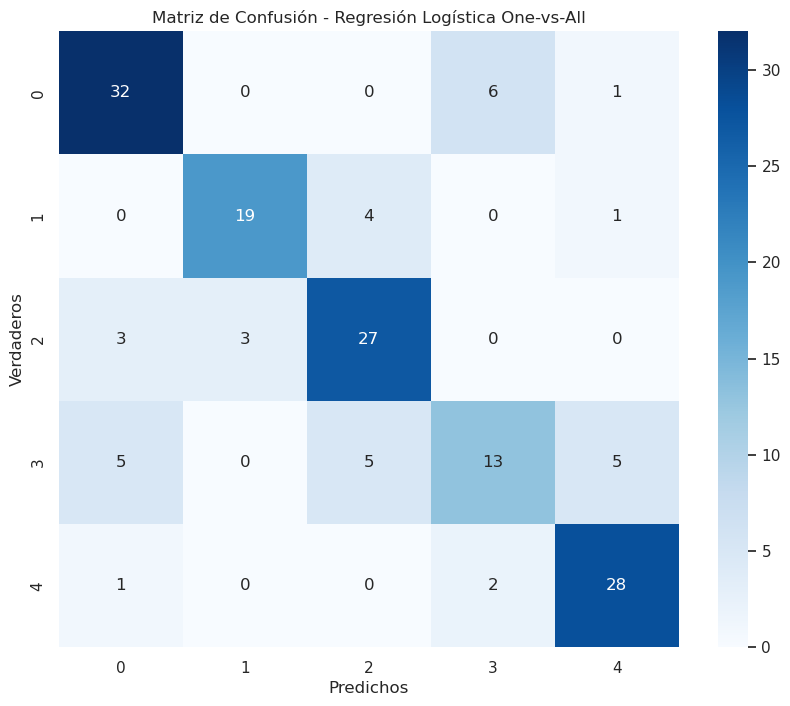


Reporte de Clasificación - One-vs-All:
              precision    recall  f1-score   support

           A       0.78      0.82      0.80        39
           B       0.86      0.79      0.83        24
           G       0.75      0.82      0.78        33
           P       0.62      0.46      0.53        28
           S       0.80      0.90      0.85        31

    accuracy                           0.77       155
   macro avg       0.76      0.76      0.76       155
weighted avg       0.76      0.77      0.76       155


Precisión en entrenamiento: 0.7417
Precisión en prueba: 0.7677

Algunas predicciones de ejemplo:
Real: G, Predicho: G
Real: S, Predicho: P
Real: S, Predicho: S
Real: B, Predicho: B
Real: S, Predicho: S


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier



# Crear el clasificador base (Regresión Logística)
base_classifier = LogisticRegression(max_iter=1000)

# Crear el clasificador One-vs-Rest (OvR) usando el clasificador base
ovr_model = OneVsRestClassifier(base_classifier)
ovr_model.fit(X_train, y_train)

# Realizar predicciones con el modelo One-vs-Rest
y_pred_ovr = ovr_model.predict(X_test)

# Evaluar el modelo: matriz de confusión
plt.figure(figsize=(10, 8))
cm_ovr = confusion_matrix(y_test, y_pred_ovr)
sns.heatmap(cm_ovr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística One-vs-All')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación - One-vs-All:")
print(classification_report(y_test, y_pred_ovr))

# Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy = ovr_model.score(X_train, y_train)
test_accuracy = ovr_model.score(X_test, y_test)
print(f"\nPrecisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")

# Mostrar algunas predicciones para algunas muestras de prueba
print("\nAlgunas predicciones de ejemplo:")
for i in range(min(5, len(y_test))):
    print(f"Real: {y_test.iloc[i]}, Predicho: {y_pred_ovr[i]}")

# SoftMax

/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


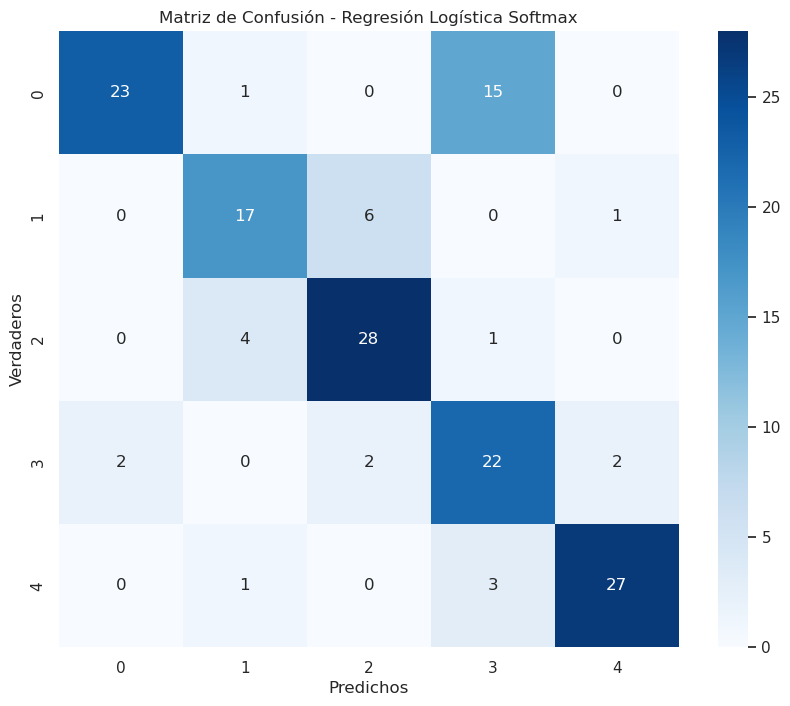


Reporte de Clasificación - Softmax:
              precision    recall  f1-score   support

           A       0.92      0.59      0.72        39
           B       0.74      0.71      0.72        24
           G       0.78      0.85      0.81        33
           P       0.54      0.79      0.64        28
           S       0.90      0.87      0.89        31

    accuracy                           0.75       155
   macro avg       0.77      0.76      0.76       155
weighted avg       0.79      0.75      0.76       155


Precisión en entrenamiento: 0.7111
Precisión en prueba: 0.7548

Algunas predicciones de ejemplo:
Real: G, Predicho: G
Real: S, Predicho: B
Real: S, Predicho: S
Real: B, Predicho: B
Real: S, Predicho: S


In [41]:
from sklearn.metrics import classification_report, confusion_matrix


# Crear el clasificador Softmax (regresión logística multinomial)
softmax_model = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')  # Solver 'lbfgs' es común para multinomial
softmax_model.fit(X_train, y_train)

# Realizar predicciones con el modelo Softmax
y_pred_softmax = softmax_model.predict(X_test)

# Evaluar el modelo: matriz de confusión
plt.figure(figsize=(10, 8))
cm_softmax = confusion_matrix(y_test, y_pred_softmax)
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística Softmax')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación - Softmax:")
print(classification_report(y_test, y_pred_softmax))

# Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy = softmax_model.score(X_train, y_train)
test_accuracy = softmax_model.score(X_test, y_test)
print(f"\nPrecisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")

# Mostrar algunas predicciones para algunas muestras de prueba
print("\nAlgunas predicciones de ejemplo:")
for i in range(min(5, len(y_test))):
    print(f"Real: {y_test.iloc[i]}, Predicho: {y_pred_softmax[i]}")

# ANN

In [ ]:
pip install keras

In [ ]:
!pip install tensorflow

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3055 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4613 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4125 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4112 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4060 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3782 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3979 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3938 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 9/10
8/8 ━━━━━━━━

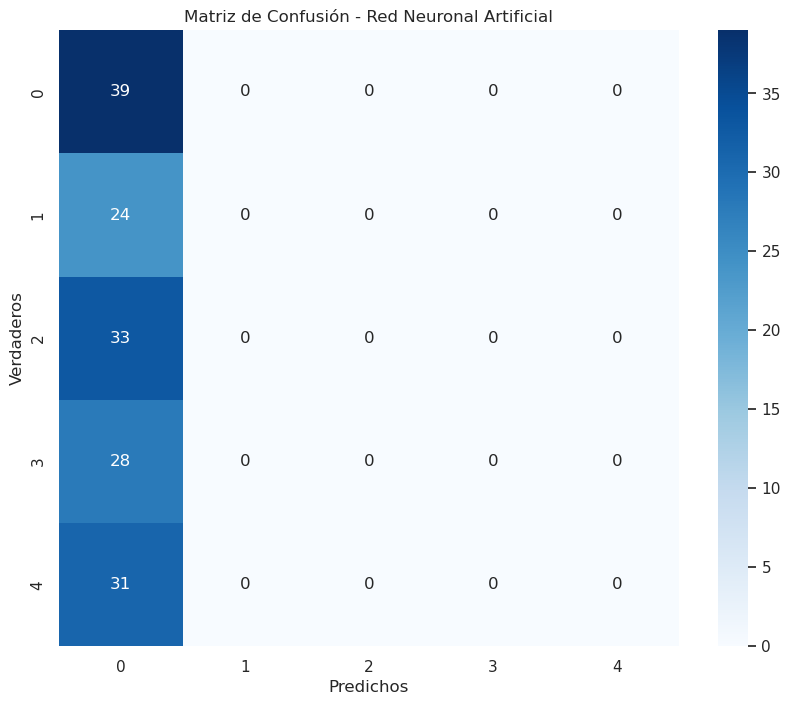

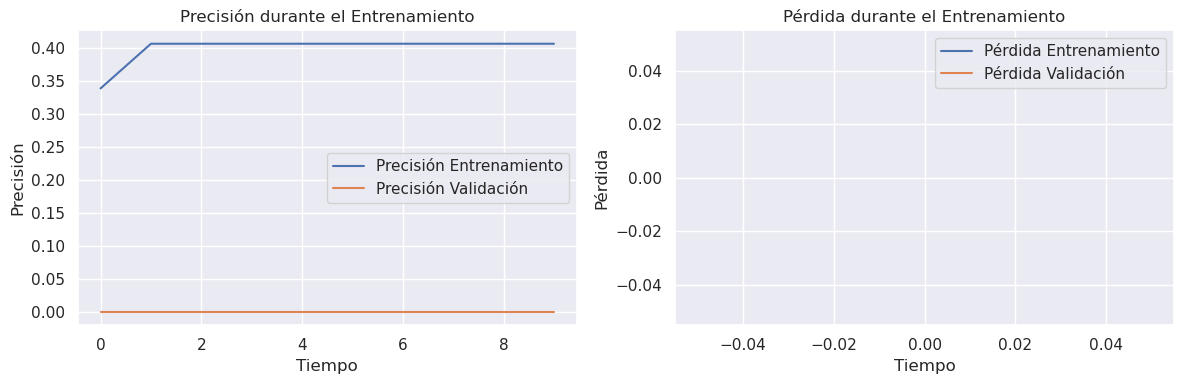


Reporte de Clasificación - ANN:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        39
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        31

    accuracy                           0.25       155
   macro avg       0.05      0.20      0.08       155
weighted avg       0.06      0.25      0.10       155



/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Construir el modelo de la Red Neuronal Artificial (ANN)
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Capa de entrada
    Dropout(0.25),  # Dropout para evitar sobreajuste
    Dense(50, activation='softmax'),  # Capa oculta
    Dropout(0.25),  # Dropout para evitar sobreajuste
    Dense(25, activation='relu'),  # Capa oculta
    Dropout(0.05),  # Dropout para evitar sobreajuste
    Dense(5, activation='relu')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.3,  # Usamos un 30% del conjunto de entrenamiento para validación
                    verbose=1)

# Evaluación en el conjunto de prueba (directamente con el modelo)
y_pred_ann = model.predict(X_test_scaled)
y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)  # Convertir las probabilidades a clases predichas

# Convertir y_test en etiquetas numéricas con el LabelEncoder
y_test_encoded = label_encoder.transform(y_test)  # Transformar las etiquetas de texto a numéricas

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm_ann = confusion_matrix(y_test_encoded, y_pred_ann_classes)  # Usar las etiquetas codificadas
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Red Neuronal Artificial')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Gráficos de la historia del entrenamiento (precisión y pérdida)
plt.figure(figsize=(12, 4))

# Precisión de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Tiempo')
plt.ylabel('Precisión')
plt.legend()

# Pérdida de entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Tiempo')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación - ANN:")
print(classification_report(y_test_encoded, y_pred_ann_classes))  # Usar las etiquetas codificadas

# Calcular Fx como las probabilidades de cada clase
Fx = tf.nn.softmax(y_pred_ann)  # Aquí Fx contiene las probabilidades de las clases predichas

#### Luego procedemos a realizar la implementacion de PCA

# Con PCA

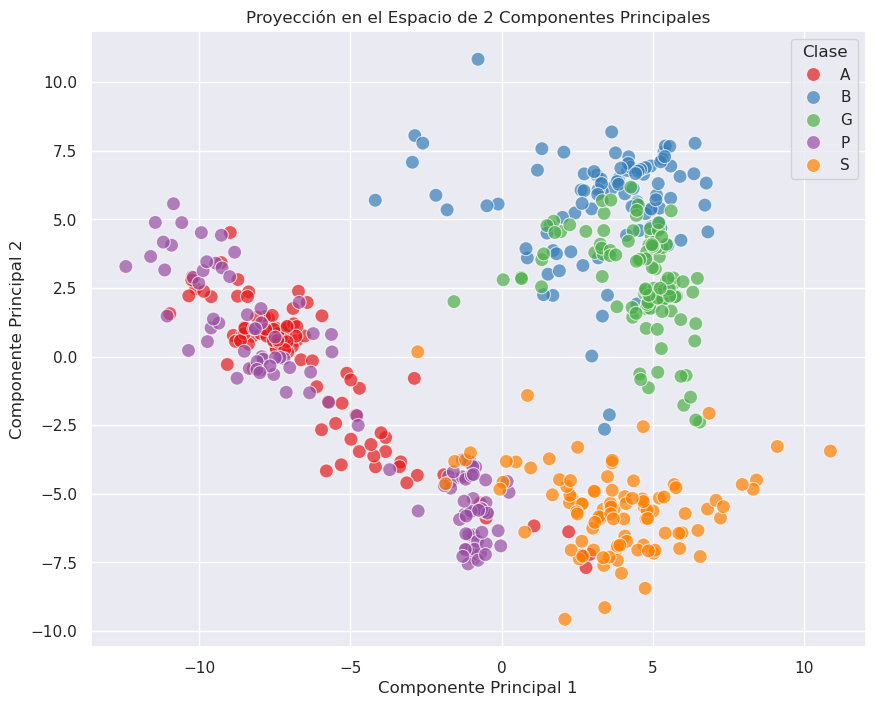

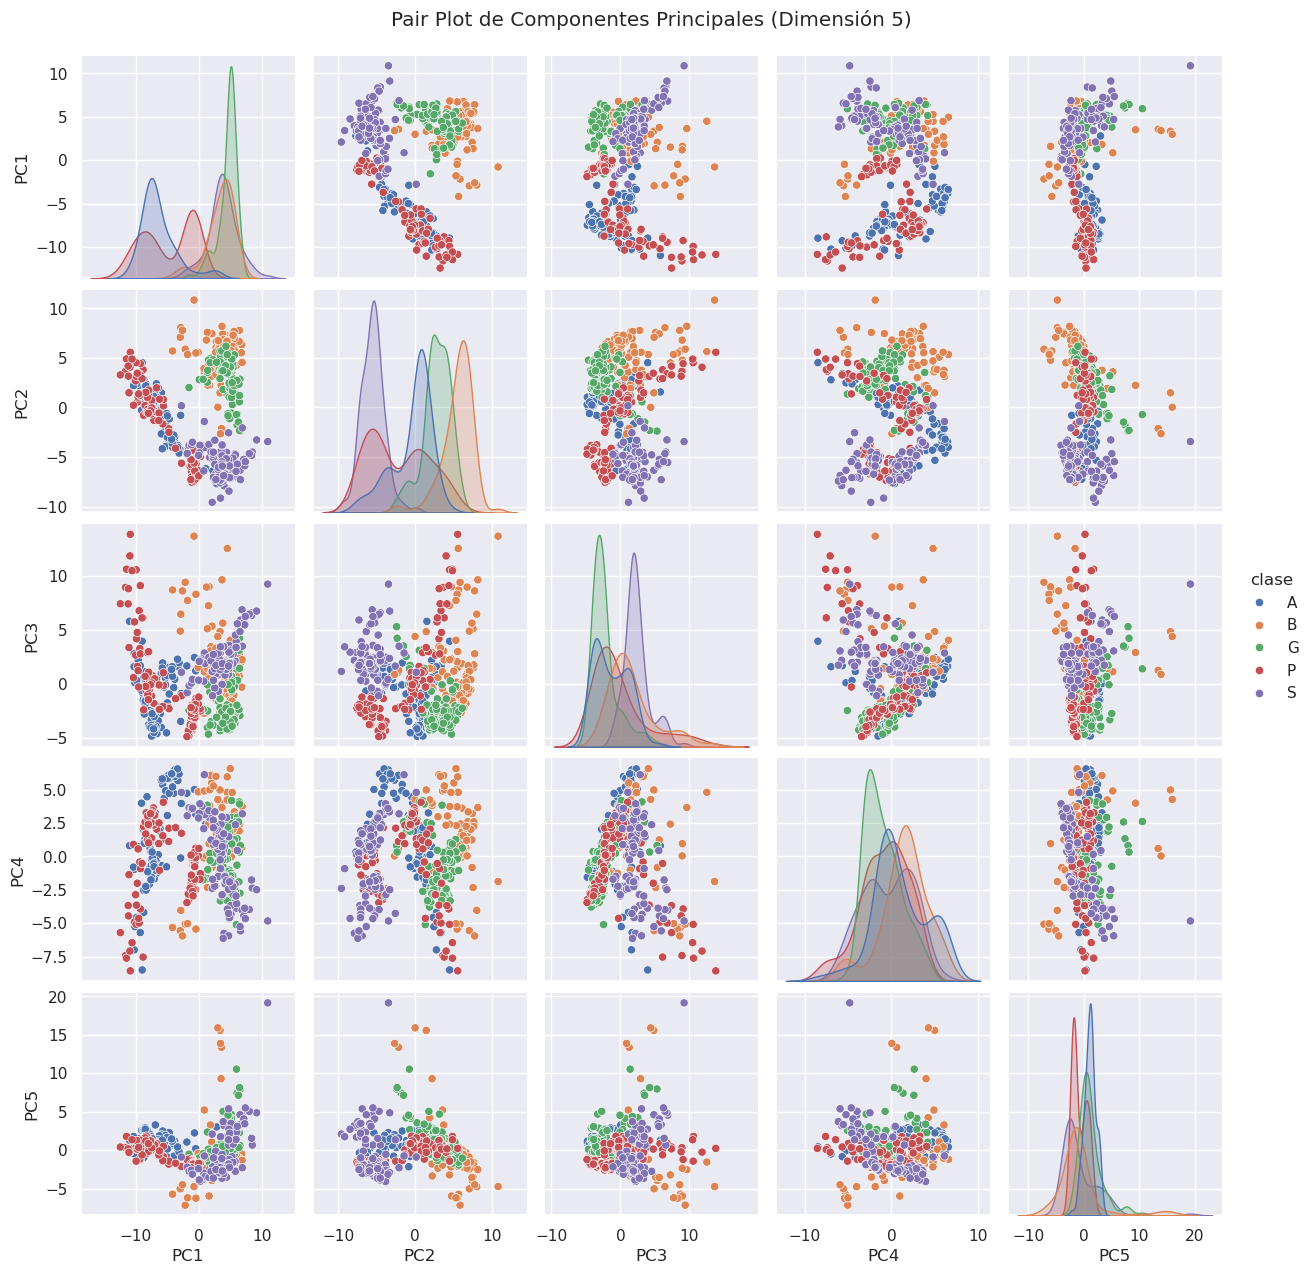

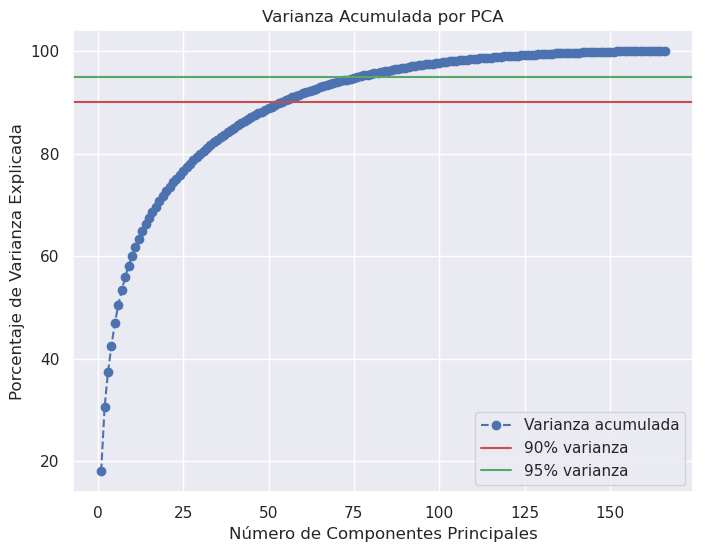

Componentes necesarios para el 90% de la varianza: 54
Componentes necesarios para el 95% de la varianza: 77


In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Cargar el archivo CSV
archivo_csv = "./caracteristicas_imagenes_final.csv"
if not os.path.exists(archivo_csv):
    raise FileNotFoundError(f"El archivo {archivo_csv} no existe.")

datos = pd.read_csv(archivo_csv)

# Separar características y etiquetas
etiquetas = datos['clase']  # Asumiendo que 'clase' contiene las etiquetas
caracteristicas = datos.drop(columns=['clase'])

# Asegurarse de que todas las características sean numéricas
caracteristicas = caracteristicas.select_dtypes(include=[np.number])

# Normalizar las características
scaler = StandardScaler()
caracteristicas_normalizadas = scaler.fit_transform(caracteristicas)


# Proyección a 2 y 5 componentes principales
for n in [2, 5]:
    pca = PCA(n_components=n)
    componentes_principales = pca.fit_transform(caracteristicas_normalizadas)

    # Crear DataFrame con las componentes principales
    df_pca = pd.DataFrame(componentes_principales, columns=[f'PC{i+1}' for i in range(n)])
    df_pca['clase'] = etiquetas

    # Gráfico para 2 componentes principales
    if n == 2:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='clase', palette='Set1', s=100, alpha=0.7)
        plt.title('Proyección en el Espacio de 2 Componentes Principales')
        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.legend(title='Clase')
        plt.grid(True)
        plt.show()

    # Gráficos pairplot para 5 componentes principales
    elif n == 5:
        sns.pairplot(df_pca, hue='clase', diag_kind='kde')
        plt.suptitle('Pair Plot de Componentes Principales (Dimensión 5)', y=1.02)
        plt.show()

# PCA: Calcular varianza acumulada para todas las componentes
pca = PCA(n_components=caracteristicas_normalizadas.shape[1])
componentes = pca.fit_transform(caracteristicas_normalizadas)

# Varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_) * 100

# Gráfico de varianza acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='o', linestyle='--', label='Varianza acumulada')
plt.axhline(y=90, color='r', linestyle='-', label='90% varianza')
plt.axhline(y=95, color='g', linestyle='-', label='95% varianza')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.title('Varianza Acumulada por PCA')
plt.legend()
plt.grid(True)
plt.show()

# Determinar el número de componentes para el 90% y 95% de la varianza
n_componentes_90 = np.argmax(varianza_acumulada >= 90) + 1
n_componentes_95 = np.argmax(varianza_acumulada >= 95) + 1

print(f"Componentes necesarios para el 90% de la varianza: {n_componentes_90}")
print(f"Componentes necesarios para el 95% de la varianza: {n_componentes_95}")

In [72]:
import pandas as pd
from sklearn.decomposition import PCA

# Función para aplicar PCA a un conjunto de características y generar un DataFrame con los componentes principales
def aplicar_pca(caracteristicas, nombre, n_componentes=None):
    pca = PCA(n_components=n_componentes)  # Ajustar componentes según sea necesario
    pca_transformado = pca.fit_transform(caracteristicas)
    # Crear DataFrame con los nuevos componentes
    pca_df = pd.DataFrame(pca_transformado, columns=[f'pca_{nombre}_{i+1}' for i in range(pca_transformado.shape[1])])
    return pca_df

# Cargar las características (asegúrate de tener los datos cargados como DataFrame)
df = pd.read_csv('./caracteristicas_imagenes_final.csv')

# Aplicar PCA a todo el DataFrame de características
# Asegúrate de que todas las columnas que quieres usar para PCA sean numéricas
# Si hay columnas no numéricas, puedes filtrarlas o eliminarlas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Aplicar PCA con un número determinado de componentes (ajustar según sea necesario)
# Ejemplo con n_componentes igual a 54, pero puedes cambiar este valor según tus necesidades
pca_df = aplicar_pca(df_numeric, 'todo', n_componentes=77)

# Guardar el resultado en un nuevo archivo CSV
pca_df.to_csv('./caracteristicas_imagenes_pca.csv', index=False)


Tamaño del conjunto de entrenamiento: 360
Tamaño del conjunto de prueba: 155


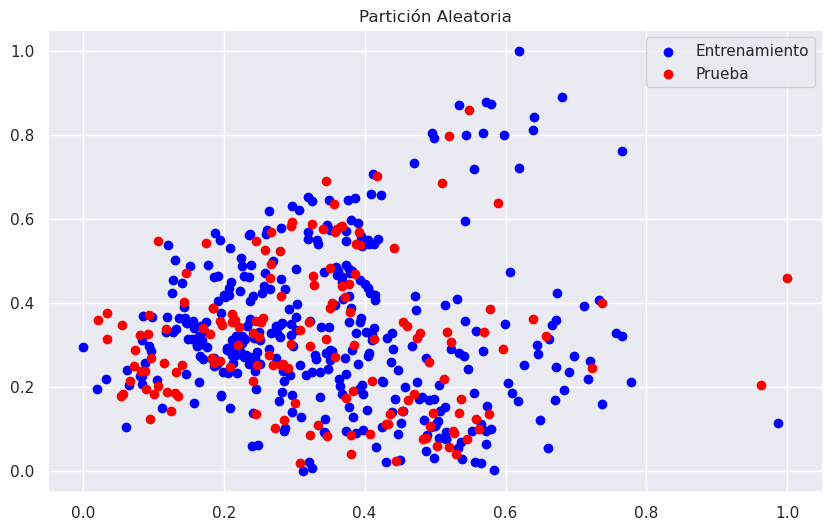

In [73]:
# Cargar el archivo generado con PCA
df_pca = pd.read_csv('./caracteristicas_imagenes_pca.csv')

# Separar las características (X) y las etiquetas (YN)
# Asumimos que las etiquetas están en una columna 'clase' en el archivo original
# Si el archivo PCA no incluye las etiquetas, debes cargarlas desde otro archivo o fuente
X = df_pca  # Las características generadas por PCA
YN = df['clase']  # Las etiquetas originales del DataFrame (si están en otro archivo o variable)

# Normalizar las características utilizando MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalizamos todas las columnas de las características generadas por PCA

# Partición Aleatoria (70% entrenamiento, 30% prueba)
X_train, X_test = train_test_split(X_normalized, test_size=0.3, random_state=42)

# Generar un eje x en función del número de datos para la visualización
N = len(X_normalized)
X_axis = np.linspace(0, N, N)

# Gráfica de la distribución de los datos (entrenamiento vs prueba)
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label='Entrenamiento')
plt.scatter(X_test[:, 0], X_test[:, 1], color='red', label='Prueba')
plt.title('Partición Aleatoria')
plt.legend()

# Imprimir tamaños de los datos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")


# SVM


Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.97      1.00      0.99        39
           B       0.85      0.96      0.90        24
           G       0.97      0.91      0.94        33
           P       1.00      0.96      0.98        28
           S       1.00      0.97      0.98        31

    accuracy                           0.96       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.96      0.96      0.96       155



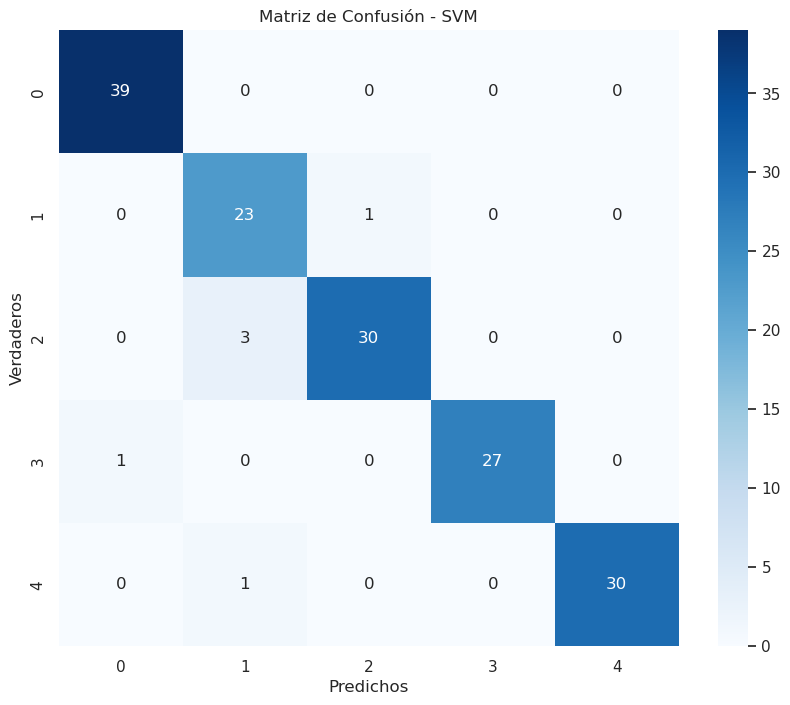


Precisión en entrenamiento: 1.0000
Precisión en prueba: 0.9613

Algunas predicciones de ejemplo:
Real: G, Predicho: G
Real: S, Predicho: S
Real: S, Predicho: S
Real: B, Predicho: B
Real: S, Predicho: S


In [74]:
from sklearn.svm import SVC

# Suponemos que las etiquetas están en una columna 'clase' en el DataFrame original
# Si las etiquetas no están en el mismo archivo, debes cargarlas desde otro archivo o fuente.
# Cargar el DataFrame original para las etiquetas
df_original = pd.read_csv('./caracteristicas_imagenes_final.csv')

# Separar las características (X) y las etiquetas (YN) del archivo original
X = df_pca  # Las características generadas por PCA
y = df_original['clase']  # Las etiquetas originales

# Normalizar las características utilizando MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normalizamos todas las columnas de las características generadas por PCA

# Partición Aleatoria (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 2. Crear y entrenar el modelo SVM con kernel RBF
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# 3. Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

# 4. Evaluar el modelo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 5. Crear y mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# 6. Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy = svm_model.score(X_train, y_train)
test_accuracy = svm_model.score(X_test, y_test)
print(f"\nPrecisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")

# 7. Mostrar algunas predicciones para algunas muestras de prueba
print("\nAlgunas predicciones de ejemplo:")
for i in range(min(5, len(y_test))):
    print(f"Real: {y_test.iloc[i]}, Predicho: {y_pred[i]}")

# OneVsAll

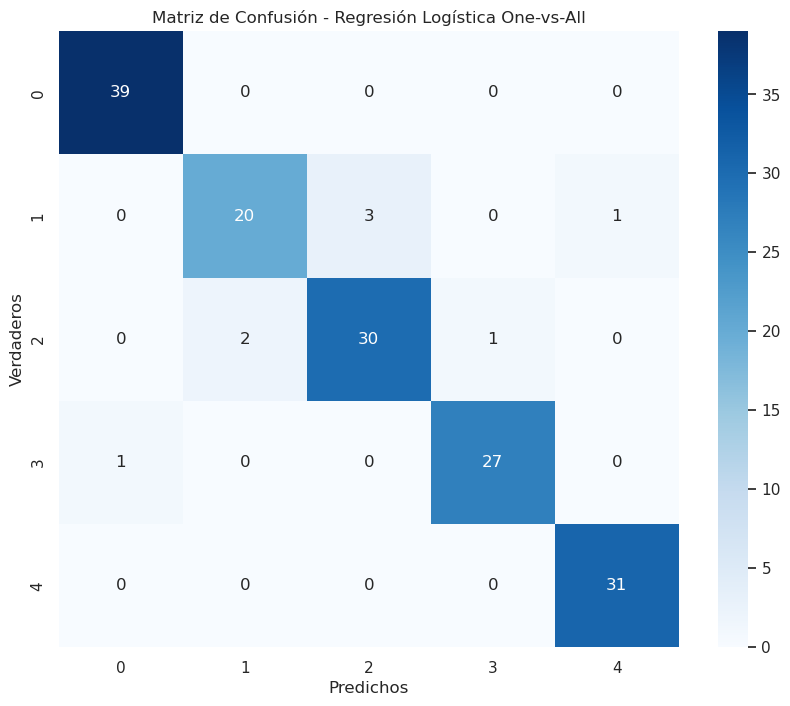


Reporte de Clasificación - One-vs-All:
              precision    recall  f1-score   support

           A       0.97      1.00      0.99        39
           B       0.91      0.83      0.87        24
           G       0.91      0.91      0.91        33
           P       0.96      0.96      0.96        28
           S       0.97      1.00      0.98        31

    accuracy                           0.95       155
   macro avg       0.95      0.94      0.94       155
weighted avg       0.95      0.95      0.95       155


Precisión en entrenamiento: 1.0000
Precisión en prueba: 0.9484

Algunas predicciones de ejemplo:
Real: G, Predicho: G
Real: S, Predicho: S
Real: S, Predicho: S
Real: B, Predicho: B
Real: S, Predicho: S


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# 1. Crear el clasificador base (Regresión Logística)
base_classifier = LogisticRegression(max_iter=1000)

# 2. Crear el clasificador One-vs-Rest (OvR) usando el clasificador base
ovr_model = OneVsRestClassifier(base_classifier)

# 3. Entrenar el modelo One-vs-Rest
ovr_model.fit(X_train, y_train)

# 4. Realizar predicciones con el modelo One-vs-Rest
y_pred_ovr = ovr_model.predict(X_test)

# 5. Evaluar el modelo: matriz de confusión
plt.figure(figsize=(10, 8))
cm_ovr = confusion_matrix(y_test, y_pred_ovr)
sns.heatmap(cm_ovr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística One-vs-All')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# 6. Reporte de clasificación
print("\nReporte de Clasificación - One-vs-All:")
print(classification_report(y_test, y_pred_ovr))

# 7. Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy = ovr_model.score(X_train, y_train)
test_accuracy = ovr_model.score(X_test, y_test)
print(f"\nPrecisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")

# 8. Mostrar algunas predicciones para algunas muestras de prueba
print("\nAlgunas predicciones de ejemplo:")
for i in range(min(5, len(y_test))):
    print(f"Real: {y_test.iloc[i]}, Predicho: {y_pred_ovr[i]}")

# SoftMax

/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


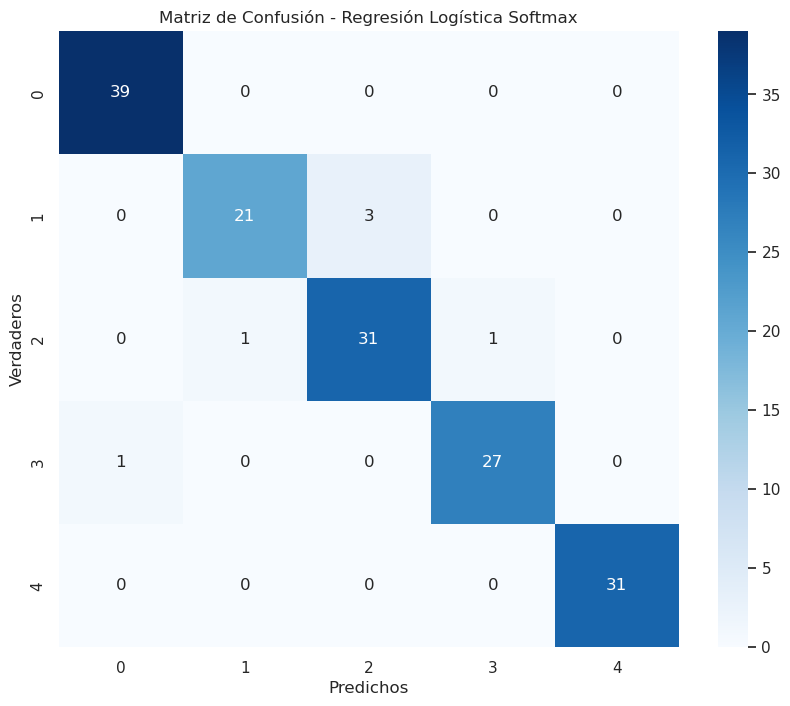


Reporte de Clasificación - Softmax:
              precision    recall  f1-score   support

           A       0.97      1.00      0.99        39
           B       0.95      0.88      0.91        24
           G       0.91      0.94      0.93        33
           P       0.96      0.96      0.96        28
           S       1.00      1.00      1.00        31

    accuracy                           0.96       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.96      0.96      0.96       155


Precisión en entrenamiento: 1.0000
Precisión en prueba: 0.9613

Algunas predicciones de ejemplo:
Real: G, Predicho: G
Real: S, Predicho: S
Real: S, Predicho: S
Real: B, Predicho: B
Real: S, Predicho: S


In [76]:
# Crear el clasificador Softmax (regresión logística multinomial)
softmax_model = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')

# Entrenar el modelo Softmax
softmax_model.fit(X_train, y_train)

# Realizar predicciones con el modelo Softmax
y_pred_softmax = softmax_model.predict(X_test)

# Evaluar el modelo: matriz de confusión
plt.figure(figsize=(10, 8))
cm_softmax = confusion_matrix(y_test, y_pred_softmax)
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística Softmax')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación - Softmax:")
print(classification_report(y_test, y_pred_softmax))

# Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy = softmax_model.score(X_train, y_train)
test_accuracy = softmax_model.score(X_test, y_test)
print(f"\nPrecisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")

# Mostrar algunas predicciones para algunas muestras de prueba
print("\nAlgunas predicciones de ejemplo:")
for i in range(min(5, len(y_test))):
    print(f"Real: {y_test.iloc[i]}, Predicho: {y_pred_softmax[i]}")

# ANN

Epoch 1/10


/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3370 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4114 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4158 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4021 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4315 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3886 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4404 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4262 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━

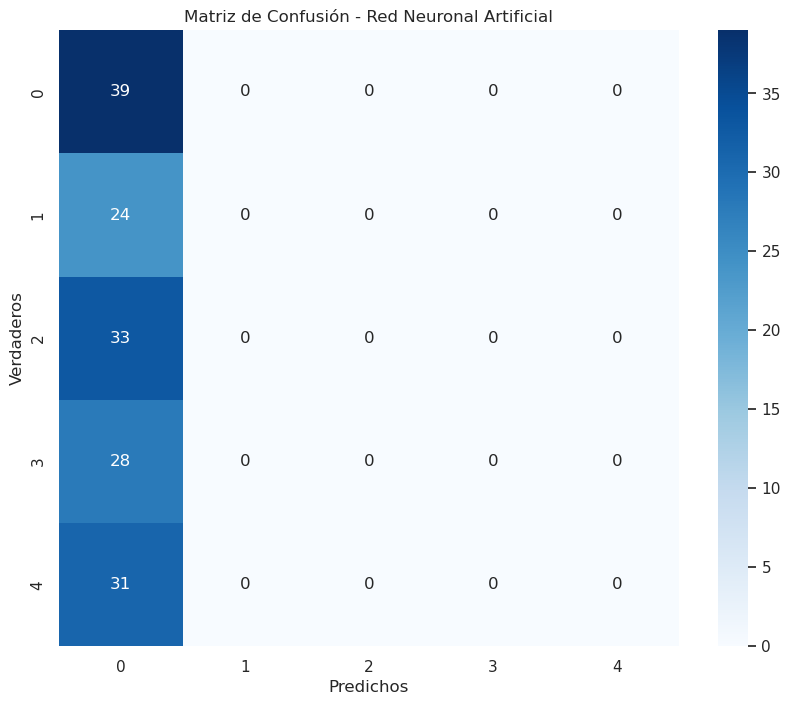

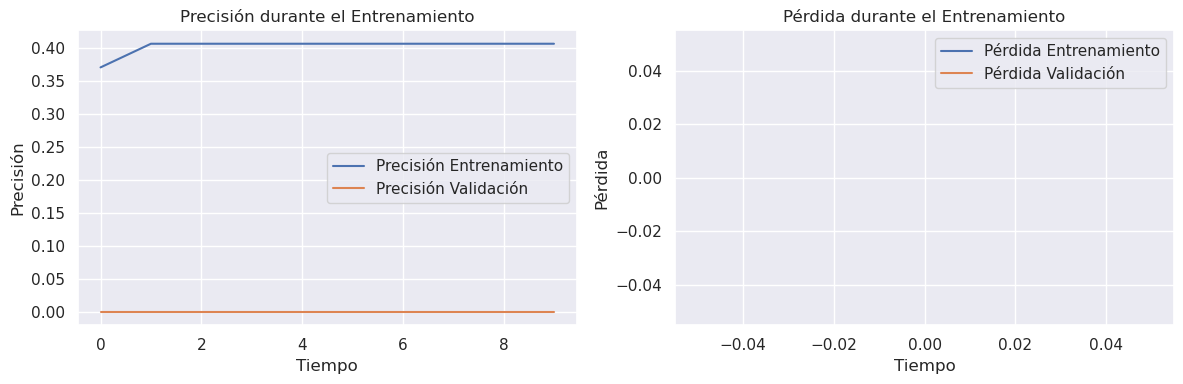


Reporte de Clasificación - ANN:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        39
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        31

    accuracy                           0.25       155
   macro avg       0.05      0.20      0.08       155
weighted avg       0.06      0.25      0.10       155



/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo-castellanos/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Construir el modelo de la Red Neuronal Artificial (ANN)
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Capa de entrada
    Dropout(0.25),  # Dropout para evitar sobreajuste
    Dense(50, activation='softmax'),  # Capa oculta
    Dropout(0.25),  # Dropout para evitar sobreajuste
    Dense(25, activation='relu'),  # Capa oculta
    Dropout(0.05),  # Dropout para evitar sobreajuste
    Dense(5, activation='relu')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.3,  # Usamos un 30% del conjunto de entrenamiento para validación
                    verbose=1)

# Evaluación en el conjunto de prueba (directamente con el modelo)
y_pred_ann = model.predict(X_test_scaled)
y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)  # Convertir las probabilidades a clases predichas

# Convertir y_test en etiquetas numéricas con el LabelEncoder
y_test_encoded = label_encoder.transform(y_test)  # Transformar las etiquetas de texto a numéricas

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm_ann = confusion_matrix(y_test_encoded, y_pred_ann_classes)  # Usar las etiquetas codificadas
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Red Neuronal Artificial')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Gráficos de la historia del entrenamiento (precisión y pérdida)
plt.figure(figsize=(12, 4))

# Precisión de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Tiempo')
plt.ylabel('Precisión')
plt.legend()

# Pérdida de entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Tiempo')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación - ANN:")
print(classification_report(y_test_encoded, y_pred_ann_classes))  # Usar las etiquetas codificadas

# Calcular Fx como las probabilidades de cada clase
Fx = tf.nn.softmax(y_pred_ann)  # Aquí Fx contiene las probabilidades de las clases predichas